In [1]:
%matplotlib inline
import nilearn.plotting as niplt
import nibabel as nib
from pathlib import Path
import pandas as pd


C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
root = Path('D:/neuroscout/datasets/SherlockMerlin/derivatives/neuroscout/Jva/fitlins/')

In [5]:
events = pd.read_hdf('d:/neuroscout/datasets/subject-19_task-MerlinMovie_events.h5')

In [6]:
pivoted = events.pivot_table(index='onset', values='amplitude', columns='condition').reset_index()

In [7]:
pivoted['n_scan'] = pivoted['onset'] / 1.5

(0, 1029)

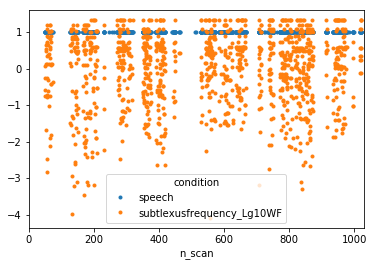

In [8]:
p = pivoted.plot(x='n_scan', y=['speech', 'subtlexusfrequency_Lg10WF'], style='.')
p.set_xlim(0, 1029)

In [368]:
mean_TR = pivoted.groupby('TR').mean().reset_index()[['TR', 'subtlexusfrequency_Lg10WF', 'speech']]

In [371]:
trs0 = pd.DataFrame({'TR': list(set(np.arange(0, 1020)) - set(mean_TR['TR']))})
trs0['speech'] = 0
trs0['subtlexusfrequency_Lg10WF'] = 0

In [373]:
mean_TR = pd.concat([mean_TR, trs0]).fillna(0)

In [379]:
mean_TR = mean_TR.sort_values('TR')

## Make Design Matrix

Summary of problems:
Nistats oversampling is weird. Raise issue, and check that with high oversampling, things HRF looks OK
Check that exclude is working properly in linux.

In [3]:
from nistats import design_matrix as dm
import nistats.hemodynamic_models as hm
from nistats.experimental_paradigm import check_paradigm

import json
from bids.analysis import Analysis
from bids.grabbids import BIDSLayout
import nibabel as nib
import numpy as np

In [4]:
model = json.load(open('d:/neuroscout/datasets/SherlockMerlin/derivatives/neuroscout/Jva/model.json'))
bids_dir = 'd:/neuroscout/datasets/SherlockMerlin'
img_file = 'd:/neuroscout/datasets/SherlockMerlin/sub-37/func/sub-37_task-MerlinMovie_run-1_bold.nii.gz'
img = nib.load(img_file)
vols = img.shape[3]

In [5]:
layout = BIDSLayout(bids_dir, exclude=".*neuroscout/(?!Jva).*")   

In [573]:
analysis = Analysis(model=model, layout=layout)
analysis.setup(derivatives='only', drop_na=False)

In [19]:
repetition_time = 1.5
sampling_rate = 1/repetition_time
resample_rate = sampling_rate * 16
frame_times=np.arange(vols) * repetition_time

In [ ]:
first = analysis.blocks[0]
on = first.output_nodes[0]

In [16]:
sparse = first.get_design_matrix(first.model['HRF_variables'], mode='sparse')

In [17]:
paradigm = sparse[0][0].rename(columns={'amplitude': 'modulation', 'condition': 'trial_type'})

In [18]:
pivot_paradigm = paradigm.pivot_table(index='onset', values='modulation', columns='trial_type').reset_index()

In [19]:
matrix = dm.make_design_matrix(frame_times=frame_times, paradigm=paradigm)

c:\users\aid338\repos\nistats\nistats\experimental_paradigm.py:57: UserWarning: 'trial_type' key not found in the given paradigm.
  warnings.warn("'trial_type' key not found in the given paradigm.")
c:\users\aid338\repos\nistats\nistats\experimental_paradigm.py:60: UserWarning: 'duration' key not found in the given paradigm.
  warnings.warn("'duration' key not found in the given paradigm.")
c:\users\aid338\repos\nistats\nistats\experimental_paradigm.py:63: UserWarning: 'modulation' key not found in the given paradigm.
  warnings.warn("'modulation' key not found in the given paradigm.")


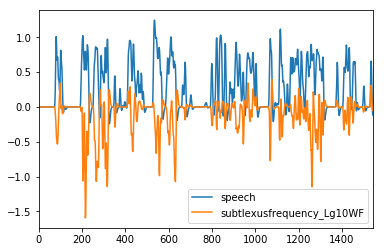

In [20]:
matrix.plot(y=['speech', 'subtlexusfrequency_Lg10WF'])

c:\users\aid338\repos\nistats\nistats\experimental_paradigm.py:57: UserWarning: 'trial_type' key not found in the given paradigm.
  warnings.warn("'trial_type' key not found in the given paradigm.")
c:\users\aid338\repos\nistats\nistats\experimental_paradigm.py:60: UserWarning: 'duration' key not found in the given paradigm.
  warnings.warn("'duration' key not found in the given paradigm.")
c:\users\aid338\repos\nistats\nistats\experimental_paradigm.py:63: UserWarning: 'modulation' key not found in the given paradigm.
  warnings.warn("'modulation' key not found in the given paradigm.")


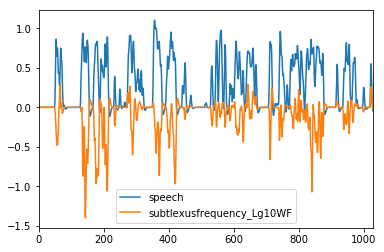

In [21]:
convolved, names = dm._convolve_regressors(paradigm, 'spm', frame_times)
convolved = pd.DataFrame(convolved, columns=names)
convolved.plot(y=['speech', 'subtlexusfrequency_Lg10WF'])

In [404]:
convolved.corr()

,speech,subtlexusfrequency_Lg10WF
speech,1.000000,-0.541693
subtlexusfrequency_Lg10WF,-0.541693,1.000000


In [216]:
trial_type, onset, duration, modulation = check_paradigm(paradigm)
condition = 'subtlexusfrequency_Lg10WF'
condition_mask = (trial_type == condition)
exp_condition = (onset[condition_mask],
                 duration[condition_mask],
                 modulation[condition_mask])

c:\users\aid338\repos\nistats\nistats\experimental_paradigm.py:57: UserWarning: 'trial_type' key not found in the given paradigm.
  warnings.warn("'trial_type' key not found in the given paradigm.")
c:\users\aid338\repos\nistats\nistats\experimental_paradigm.py:60: UserWarning: 'duration' key not found in the given paradigm.
  warnings.warn("'duration' key not found in the given paradigm.")
c:\users\aid338\repos\nistats\nistats\experimental_paradigm.py:63: UserWarning: 'modulation' key not found in the given paradigm.
  warnings.warn("'modulation' key not found in the given paradigm.")


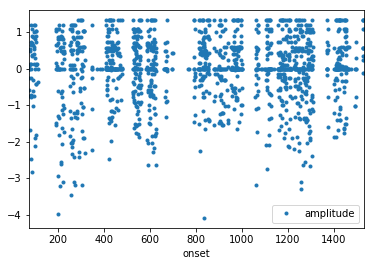

In [217]:
exp_condition_df = pd.DataFrame(np.array(exp_condition).T, columns=['onset', 'duration', 'amplitude'])
exp_condition_df = exp_condition_df.sort_values('onset')
exp_condition_df.plot(x='onset',y='amplitude', kind='line', style='.')

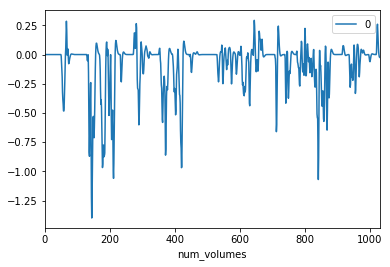

In [395]:
nis_out = hm.compute_regressor(exp_condition, 'spm', frame_times, oversampling=50)[0]
p = pd.DataFrame(nis_out).plot()
p.set_xlabel('num_volumes')

In [401]:
nis_out.mean()

-0.088976560477274105

## Nipype

(0, 1029)

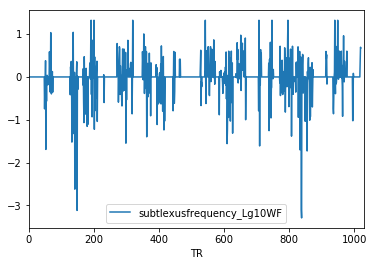

In [380]:
p = mean_TR.plot(x='TR', y=['subtlexusfrequency_Lg10WF'])
p.set_xlim(0, 1029)

In [446]:
mean_TR.corr()

,TR,speech,subtlexusfrequency_Lg10WF
TR,1.000000,0.105991,0.052060
speech,0.105991,1.000000,-0.048288
subtlexusfrequency_Lg10WF,0.052060,-0.048288,1.000000


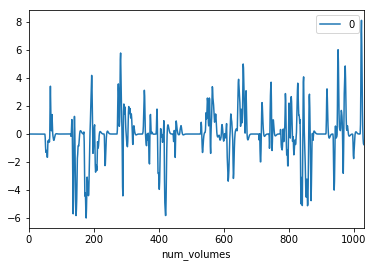

In [385]:
p = pd.DataFrame(out.outputs.session_info[0]['regress'][0]['val']).plot()
p.set_xlabel('num_volumes')

In [402]:
np.mean(out.outputs.session_info[0]['regress'][0]['val'])

0.0020918511919761438

In [58]:
from nipype.algorithms.modelgen import SpecifySparseModel
from nipype.interfaces.base import Bunch

In [282]:
on = paradigm[paradigm.trial_type==condition]['onset'].tolist()
dur = paradigm[paradigm.trial_type==condition]['duration'].tolist()
amp = paradigm[paradigm.trial_type==condition]['modulation'].tolist()
evs = Bunch(conditions=['we'], onsets=[on], durations=[dur], amplitudes=[amp])


In [384]:
s = SpecifySparseModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = [img_file]
s.inputs.time_repetition = repetition_time
s.inputs.time_acquisition = repetition_time / 10
s.inputs.high_pass_filter_cutoff = 128
s.inputs.model_hrf = True
s.inputs.subject_info = [evs]
out = s.run()

180531-12:55:06,897 interface INFO:
	 Setting dt = 15 ms

180531-12:55:06,904 interface INFO:
	 response sum: 1.0000 max: 0.0032
180531-12:55:06,905 interface INFO:
	 reg_scale: 316.7041


In [397]:
np.corrcoef([out.outputs.session_info[0]['regress'][0]['val'], nis_out.squeeze()])

array([[ 1.        ,  0.68771613],
       [ 0.68771613,  1.        ]])

### TODO
- Compare speech and frequency using to_dense sparse events (is averaging the problem?, taking into account durations). There should be no systematic negative relationship
- If no correlation, downsample to ~1s (multiples if resampling twice), and feed that into nipype and nistats. Compare, and see correlations between variables. If look similar, then run models

In [507]:
from bids.analysis import transformations

In [575]:
collection = first.output_nodes[0].collection

In [582]:
collection.variables['speech'].values = collection.variables['speech'].values.astype('float')

In [607]:
transformations.orthogonalize(collection, 'subtlexusfrequency_Lg10WF', ['speech'], output='freq_orth', dense=True)

c:\users\aid338\repos\pybids\bids\analysis\transformations\base.py:338: UserWarning: Found a mix of dense and sparse variables. May cause problems for some transformations. Sparse variables ['speech'] were converted to dense form to ensure proper alignment.
  warnings.warn(msg)


In [630]:
collection.variables['freq_orth'].values.corrwith(collection.variables['speech'].to_dense(10).values)

0    1.499019e-15
dtype: float64

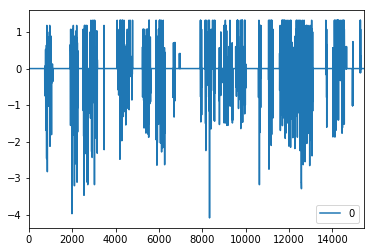

In [609]:
collection.variables['subtlexusfrequency_Lg10WF'].to_dense(10).values.plot()

In [632]:
sparse = first.get_design_matrix(first.model['HRF_variables'], mode='sparse', force=True)

In [637]:
sparse_coll = sparse[0][0]

In [532]:
dense_paradigm = dense[0][1]

In [533]:
dense_paradigm.plot(y=['speech', 'subtlexusfrequency_Lg10WF'])

KeyError: "['speech'] not in index"

In [503]:
dense_paradigm.corr()

,speech,subtlexusfrequency_Lg10WF
speech,1.000000,-0.614525
subtlexusfrequency_Lg10WF,-0.614525,1.000000


In [504]:
dense_paradigm[dense_paradigm.speech != 0.0].mean()

speech                       1.000000
subtlexusfrequency_Lg10WF   -0.817736
dtype: float64

In [440]:
sparse_paradigm = sparse[0][0]

In [468]:
sparse_paradigm.pivot_table(index='onset', values='amplitude', columns='condition').mean()`b

condition
speech                       1.000000e+00
subtlexusfrequency_Lg10WF    1.476357e-14
dtype: float64

### Orth transformations

TODO:
transformations: standardize (replace nan with 0), densify, orth freq w.r.t speech (removes corr)
hack fitlins to pass dense events as sparse (if im lucky )
Check if convolving is OK

In [6]:
model = json.load(open('d:/neuroscout/datasets/SherlockMerlin/derivatives/neuroscout/Jva/model.json'))


In [7]:
model['blocks'][0]['transformations'] = [{'input': 'subtlexusfrequency_Lg10WF',
  'name': 'scale',
  'replace_nan': 'after'},
 {'input': ['speech', 'subtlexusfrequency_Lg10WF'],
  'name': 'to_dense',
  },
 {'input': 'subtlexusfrequency_Lg10WF',
  'name': 'orthogonalize',
  'other': ['speech']}
]


In [74]:
json.dumps(model['blocks'][0]['transformations'])

'[{"input": "subtlexusfrequency_Lg10WF", "name": "scale", "replace_nan": "after"}, {"input": ["speech", "subtlexusfrequency_Lg10WF"], "name": "to_dense"}, {"other": ["speech"], "input": "subtlexusfrequency_Lg10WF", "name": "orthogonalize"}]'

In [8]:
analysis = Analysis(model=model, layout=layout)
analysis.setup(derivatives='only', drop_na=False)

In [20]:
first = analysis.blocks[0]
coll = analysis.blocks[0].output_nodes[0].collection

In [13]:
coll.variables

{'FramewiseDisplacement': <bids.variables.variables.DenseRunVariable at 0x201ae8b0320>,
 'RotX': <bids.variables.variables.DenseRunVariable at 0x201ae8bdf60>,
 'RotY': <bids.variables.variables.DenseRunVariable at 0x201ae8bdf98>,
 'RotZ': <bids.variables.variables.DenseRunVariable at 0x201ae8ce630>,
 'X': <bids.variables.variables.DenseRunVariable at 0x201ae8b0ef0>,
 'Y': <bids.variables.variables.DenseRunVariable at 0x201ae8b0be0>,
 'Z': <bids.variables.variables.DenseRunVariable at 0x201ae8bd518>,
 'aCompCor00': <bids.variables.variables.DenseRunVariable at 0x201ae8ce668>,
 'aCompCor01': <bids.variables.variables.DenseRunVariable at 0x201ae8ce9b0>,
 'aCompCor02': <bids.variables.variables.DenseRunVariable at 0x201ae8cee48>,
 'aCompCor03': <bids.variables.variables.DenseRunVariable at 0x201ae8cecf8>,
 'aCompCor04': <bids.variables.variables.DenseRunVariable at 0x201ae8d30f0>,
 'aCompCor05': <bids.variables.variables.DenseRunVariable at 0x201ae8d3a20>,
 'speech': <bids.variables.variab

In [23]:
sparse = first.get_design_matrix(first.model['HRF_variables'], mode='sparse', force=True)
paradigm = sparse[0][0].rename(columns={'amplitude': 'modulation', 'condition': 'trial_type'})

In [76]:
dense = first.get_design_matrix(mode='dense')[0][1]

In [82]:
dense_vars = set(first.model['variables']) - set(first.model['HRF_variables'])
first.get_design_matrix(dense_vars, mode='dense')[0][1]

,task,type,modality,subject,FramewiseDisplacement,RotX,RotY,RotZ,X,Y,Z,aCompCor00,aCompCor01,aCompCor02,aCompCor03,aCompCor04,aCompCor05
0,MerlinMovie,bold,func,19,NaN,0.003047,-0.000724,-0.000973,0.058543,-0.021890,0.000279,0.023107,-0.010744,0.002962,-0.032415,0.017171,-0.002457
1,MerlinMovie,bold,func,19,0.145823,0.002236,-0.000724,-0.001225,0.053070,0.045669,0.019881,0.024052,0.026649,-0.037980,-0.003414,-0.044368,-0.010606
2,MerlinMovie,bold,func,19,0.149787,0.002842,-0.000364,-0.001383,0.040762,0.027378,-0.043102,0.001183,-0.010951,-0.023762,0.021851,0.006412,0.024142
3,MerlinMovie,bold,func,19,0.140325,0.001997,-0.000335,-0.001045,0.035397,0.071302,-0.012653,-0.017123,0.001894,-0.018567,-0.036252,-0.008363,-0.032446
4,MerlinMovie,bold,func,19,0.231569,0.000751,0.000147,-0.000634,0.030196,0.164201,0.013867,0.050849,0.033618,-0.018429,0.044752,-0.038862,-0.023331
5,MerlinMovie,bold,func,19,0.368591,0.002273,0.000483,-0.001026,0.005171,-0.011981,-0.041007,-0.012083,-0.026898,0.029218,0.046931,0.011688,0.006017
6,MerlinMovie,bold,func,19,0.201724,0.001131,0.000376,-0.001454,0.010057,0.066962,-0.006965,0.014514,-0.013586,0.074753,-0.019243,-0.009665,0.027825
7,MerlinMovie,bold,func,19,0.189959,0.001604,-0.000152,-0.002103,-0.015636,0.089765,-0.065924,0.045162,-0.049650,0.002612,0.005934,-0.062035,0.015961
8,MerlinMovie,bold,func,19,0.222347,0.002198,0.000200,-0.001770,-0.015224,-0.029522,-0.027159,-0.024357,-0.021762,0.023047,0.014165,-0.033168,-0.006059
9,MerlinMovie,bold,func,19,0.232006,0.000857,0.000281,-0.001094,-0.018321,0.087820,-0.033823,0.051232,0.014535,0.002648,0.013195,0.027513,0.037669


In [52]:
matrix = dm.make_design_matrix(frame_times=frame_times, paradigm=paradigm, oversampling=16)

c:\users\aid338\repos\nistats\nistats\experimental_paradigm.py:57: UserWarning: 'trial_type' key not found in the given paradigm.
  warnings.warn("'trial_type' key not found in the given paradigm.")
c:\users\aid338\repos\nistats\nistats\experimental_paradigm.py:60: UserWarning: 'duration' key not found in the given paradigm.
  warnings.warn("'duration' key not found in the given paradigm.")
c:\users\aid338\repos\nistats\nistats\experimental_paradigm.py:63: UserWarning: 'modulation' key not found in the given paradigm.
  warnings.warn("'modulation' key not found in the given paradigm.")


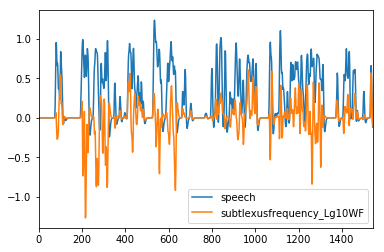

In [53]:
matrix.plot(y=['speech', 'subtlexusfrequency_Lg10WF'])

In [65]:
condition

'subtlexusfrequency_Lg10WF'

In [66]:
on = paradigm[paradigm.trial_type==condition]['onset'].tolist()
dur = paradigm[paradigm.trial_type==condition]['duration'].tolist()
amp = paradigm[paradigm.trial_type==condition]['modulation'].tolist()
evs = Bunch(conditions=[condition], onsets=[on], durations=[dur], amplitudes=[amp])


In [67]:
s = SpecifySparseModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = [img_file]
s.inputs.time_repetition = repetition_time
s.inputs.time_acquisition = repetition_time / 10
s.inputs.high_pass_filter_cutoff = 128
s.inputs.model_hrf = True
s.inputs.subject_info = [evs]
out = s.run()

180531-17:17:41,817 interface INFO:
	 Setting dt = 15 ms

180531-17:17:41,823 interface INFO:
	 response sum: 1.0000 max: 0.0032
180531-17:17:41,824 interface INFO:
	 reg_scale: 316.7041


In [71]:
np.corrcoef([out.outputs.session_info[0]['regress'][0]['val'], matrix[condition]])

array([[ 1.        ,  0.97084142],
       [ 0.97084142,  1.        ]])

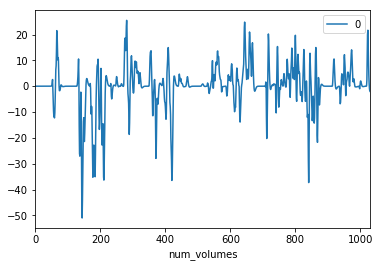

In [72]:
p = pd.DataFrame(out.outputs.session_info[0]['regress'][0]['val']).plot()
p.set_xlabel('num_volumes')

In [83]:
import nilearn.plotting as niplt

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


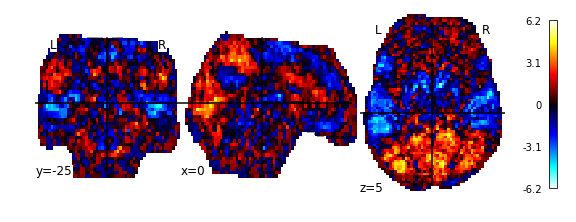

In [84]:
niplt.plot_stat_map('d:/neuroscout/datasets/SherlockMerlin/derivatives/neuroscout/Jva/fitlins/task-MerlinMovie_bold_space-MNI152NLin2009cAsym_contrast-subtlexusfrequencyLg10Wf_stat.nii.gz')

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


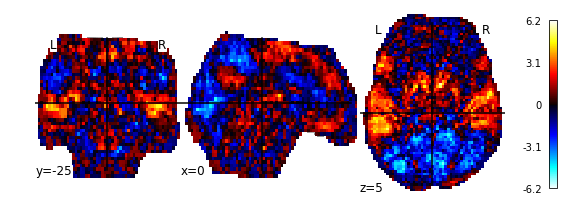

In [85]:
niplt.plot_stat_map('d:/neuroscout/datasets/SherlockMerlin/derivatives/neuroscout/Jva/fitlins/task-MerlinMovie_bold_space-MNI152NLin2009cAsym_contrast-speech_stat.nii.gz')

## Average of first level

In [87]:
root_dir = Path('d:/neuroscout/datasets/SherlockMerlin/derivatives/neuroscout/Jva/fitlins/')

In [ ]:
nib.

In [91]:
speech = [nib.load(f.as_posix()) for f in root_dir.glob('sub*/*contrast-speech_stat.nii.gz')]

In [93]:
speech_data = []

In [126]:
def avg_imgs(images):
    net = None
    for img in images:
        if net is None:
            net = img
        else:
            data = net.get_data()
            data[:] = data+img.get_data()
    data = net.get_data()
    data[:] = data / len(images)
    
    return net

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


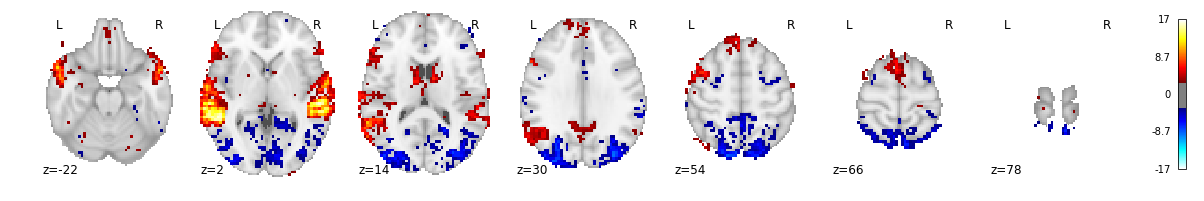

In [131]:
speech = avg_imgs([nib.load(f.as_posix()) for f in root_dir.glob('sub*/*contrast-*speech*_stat.nii.gz')])
niplt.plot_stat_map(net, display_mode='z', threshold=3)

In [128]:
freq = avg_imgs([nib.load(f.as_posix()) for f in root_dir.glob('sub*/*contrast-*freq*_stat.nii.gz')])

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


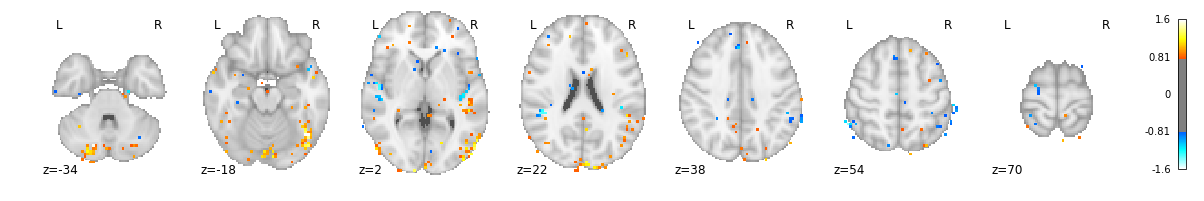

In [132]:
niplt.plot_stat_map(freq, threshold=0.8, display_mode='z')


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


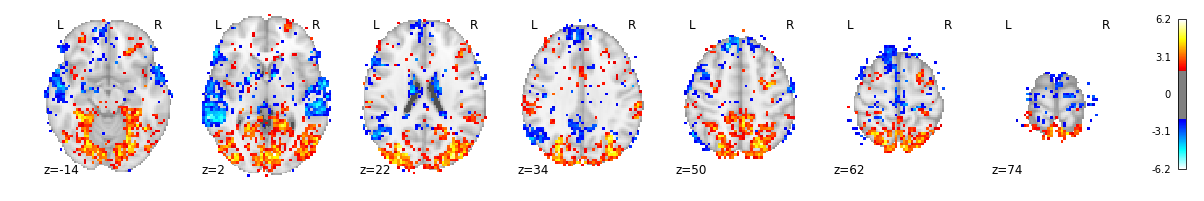

In [142]:
niplt.plot_stat_map('d:/neuroscout/datasets/freq_test2nd.nii.gz', threshold=2, display_mode='z')

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


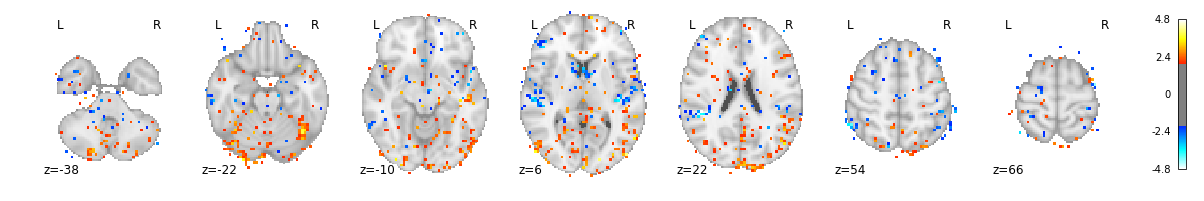

In [145]:
niplt.plot_stat_map('d:/neuroscout/datasets/freqonly_test2nd.nii.gz', threshold=2, display_mode='z')

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


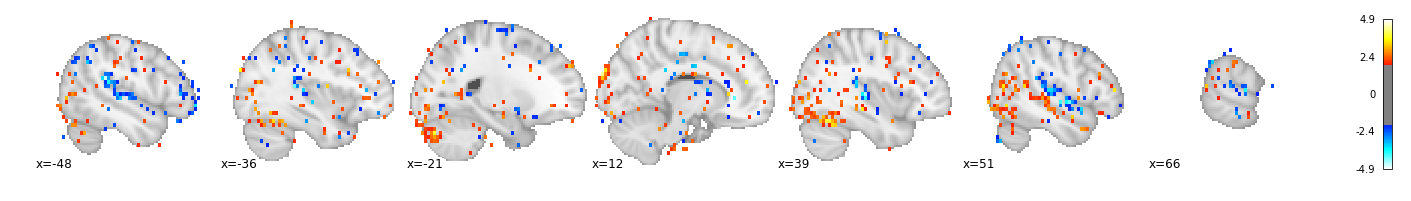

In [151]:
niplt.plot_stat_map('d:/neuroscout/datasets/freq_only_intercept.nii.gz', threshold=2, display_mode='x',
                 )

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


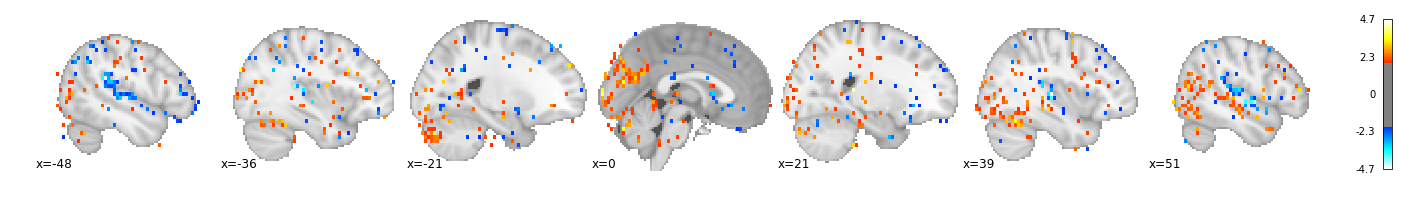

In [152]:
niplt.plot_stat_map('d:/neuroscout/datasets/SherlockMerlin/derivatives/neuroscout/Jva/fitlins/task-MerlinMovie_bold_space-MNI152NLin2009cAsym_contrast-subtlexusfrequencyLg10Wf_stat.nii.gz', threshold=2, display_mode='x')

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


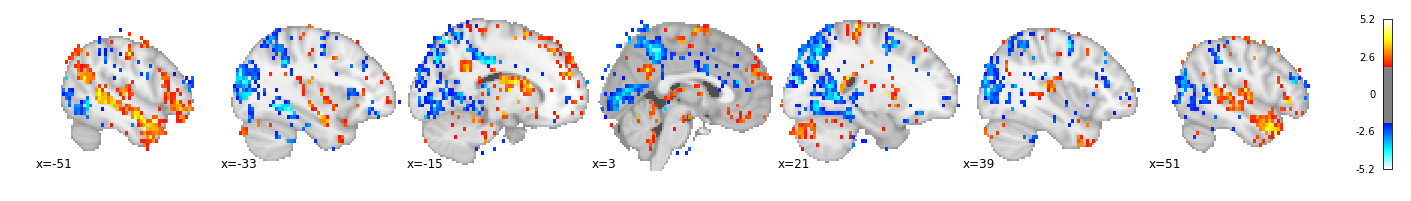

In [153]:
niplt.plot_stat_map('d:/neuroscout/datasets/SherlockMerlin/derivatives/neuroscout/Jva/fitlins/task-MerlinMovie_bold_space-MNI152NLin2009cAsym_contrast-speech_stat.nii.gz', threshold=2, display_mode='x')